In [1]:
class NodePair:    
    def __init__(self,node1,node2,relation):
        self.entity1=node1
        self.entity2=node2
        self.relation=relation
        self.coVector={}
        #self.sent = node1+relation+node2
        
        
class Node:
    def __init__(self,name,verb=""):
        self.name=name
        self.verb=verb
          
        

class NodeSpliter:
    def __init__(self,chunks) :
        self.chunks= chunks
        self.pairs=[]
        self.words_count_dict={}#紀錄 <字,字數>的字典 
    
    def split(self):
        if len(self.chunks)<1:
            return
        
        self.mainSubject= self.chunks[0].lemma_
        self.rootVerb=""
        self.nounBuffer=""
        _nextIndex=0
        for i in range(1,len(self.chunks)):
            if i<_nextIndex:
                continue
            
            c= self.chunks[i]
            #----------- 找Obj-------------            
            object_noun ,end = self.findNounRange(self.chunks[i:])
            
            #----------- 找relation-------------            
            obj_chunk=self.chunks[min(i+end ,len(self.chunks)-1)] #用obj所屬的chunk的動詞決定   
            for j_chunks in self.chunks[i:]:                
                if j_chunks.root.head.pos_  in ['AUX',"VERB","ADP","SCONJ"]:
                    if j_chunks.root.head.dep_ not in ["pcomp" , "acl",'advcl']:
                        #self.rootVerb=j_chunks.root.head.lemma_
                        self.rootVerb=j_chunks.root.head.lower_
                        break
                            
            
            #組合node
            subjectNode = Node(self.mainSubject)
            objectNode = Node(object_noun)
            self.pairs.append(NodePair(subjectNode,objectNode,self.rootVerb))
            
            # 重置
            self.mainSubject=self.nounBuffer
            self.rootVerb=""
            self.nounBuffer=""
            _nextIndex=i+end+1
            
        _allCount = len(self.pairs)
        self.pairs= list(filter(lambda p : p.relation!="",self.pairs))
        print("減去空白關聯",_allCount - len(self.pairs),"個")
        return self.pairs
        
    
  
    def findNounRange(self,chunks):
        #self.nounBuffer=""
        if len(chunks)==1:
           return chunks[0].lemma_ , len(self.chunks)
       
        endIndex=0
        j=0
        while j <len(chunks): 
            print("find noun range ", self.nounBuffer) 
            c=chunks[j]
            #direct object或PROPN(專有名詞) =>結束
            _text=c.lemma_
            #_text=c.lower_
            print("current chunks ", _text) 
            if c.root.dep_ in ["dobj","nsubj",'attr'] or c.root.pos_ in ["PROPN"]:            
                #self.nounBuffer+=chunks[j].lemma_+" "
                # ====== 判斷head是否為形容詞 =======
                if c.root.head.dep_ in ["pcomp",'advcl']: #後綴用
                    self.nounBuffer= self.nounBuffer+" "+ _text +" " + c.root.head.text
                elif c.root.head.dep_ in ["acl","prep"]: #前綴用
                    self.nounBuffer=  self.nounBuffer+c.root.head.text+" "+_text
                else:
                    self.nounBuffer+=_text
                
                endIndex=j
                print("== dobj end ==",self.nounBuffer)
                return self.nounBuffer , endIndex
                break
            
            elif c.root.dep_ =="pobj":
                self.nounBuffer =_text+" "+self.nounBuffer               
            print()
           
            j+=1
        endIndex=j
        print('找到obj: ',self.nounBuffer)
        return self.nounBuffer , endIndex

def pairs_trim(pairs):
        result_pairs= pairs.copy()
        for i in range(0,len(pairs)):
            for j in range(i+1,len(pairs)):
                sent1=pairs[i].entity1.name
                sent2=pairs[j].entity1.name
                sents=[sent1,sent2]
                #依照長度排a,b
                a,b= min(sents,key=len),max(sents,key=len)
                isOrdered= ([a,b]==sents)
                #計算a(短的)占比b中多少字
                b_wordCount= max(len(b.split()),1)
                sim= b.count(a) / b_wordCount
                print(a,b,sim)                
                
                if sim==1:
                    continue;
                elif sim>0.8:#幾乎重複
                    result_pairs.remove(pairs[i])
                    result_pairs.remove(pairs[j])
                    print(" [刪除] 幾乎重複的node ", sent1, sent2)
                elif sim>0.65:
                    #建立關聯
                    if isOrdered: #短的在前
                        newPair=NodePair(Node(sent1),Node(sent2),"about")
                    else:
                        newPair=NodePair(Node(sent2),Node(sent1),"about")
                        
                    print(" [新增] 新關聯 ", sent1, sent2)
                    result_pairs.append(newPair)                    
                pass
            pass
        return result_pairs
        pass
    
    

In [2]:
from spacy.tokens import Doc
from ARHelper import AnaphoraResolutionHelper
from Id_tdfHelper import idfHelper
from LsaHelper import LsaHelper
#from Neo4jHelper import Neo4JHelper
#from NodePair import Node, NodePair, NodeSpliter
from SBDHelper import SbdHelper
from TextCleaner import textCleaner
from WikiHelper import wikiHelper
import spacy
import numpy as np
import neuralcoref
import matplotlib.pyplot as plt
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_sm")

In [3]:

def setupNLP(nlp):
    nlp_tc, nlp_ar = nlp,nlp
    nlp_tc.add_pipe(nlp.create_pipe('sentencizer'))
    #--------- 合併斷句 ------------
    sbd= SbdHelper()
    Doc.set_extension("briefSents" , default=None , force=True)
    nlp_tc.add_pipe(sbd.briefSbd, after="sentencizer",name="sbd")
    
    print(nlp_tc == nlp_ar)
    
    
setupNLP(nlp)
disabled = nlp.disable_pipes(["sentencizer","sbd",]);
nlp_full = nlp

True


In [9]:
wiki = wikiHelper()
#text= wiki.GetLocalPage("Sword_Art_Online")
#text="In October 2006, 18 months after posting YouTube's first video and 10 months after YouTube's official launch, YouTube was bought by Google for $1.65 billion."
#text='The series takes place in the near future and focuses on protagonists Kazuto "Kirito" Kirigaya and Asuna Yuuki as they play through various virtual reality MMORPG worlds.'
#text="YouTube also approved creators to participate in Google's AdSense program, which seeks to generate more revenue for both parties."
#text="Difficulty in finding enough dating videos led to a change of plans, with the site's founders deciding to accept uploads of any type of video."
#text ='Wang signed as an amateur free agent with the Yankees in 2000.'
#text ="Python is often described as a 'batteries included' language due to Python's comprehensive standard library."
text="Python is a high-level, general-purpose programming language."
#text="The first eight volumes of the light novel series told the story arcs for Sword Art Online, Alfheim Online, and Gun Gale Online."
#text='Pygame was originally written by Pete Shinners to replace PySDL after its development stalled.'
#text="Pygame is a cross-platform set of Python modules designed for writing video games."
#text="Pygame is a cross-platform set of Python modules designed for writing video games. Pygame was originally written by Pete Shinners to replace PySDL after its development stalled."

doc = nlp_full(text)
nuns=list(doc.noun_chunks)
        
spliter=NodeSpliter(nuns) #合併noun chunks
pairs=spliter.split()
pairs = pairs_trim(pairs)
for pair in pairs:
    #print(pair.entity1.name)
    print(pair.entity1.name,"-> [",pair.relation,"] ->",pair.entity2.name) 


減去空白關聯 0 個
Python -> [ is ] -> a high - level , general - purpose programming language


Python Python nsubj is
a high-level, general-purpose programming language language attr is


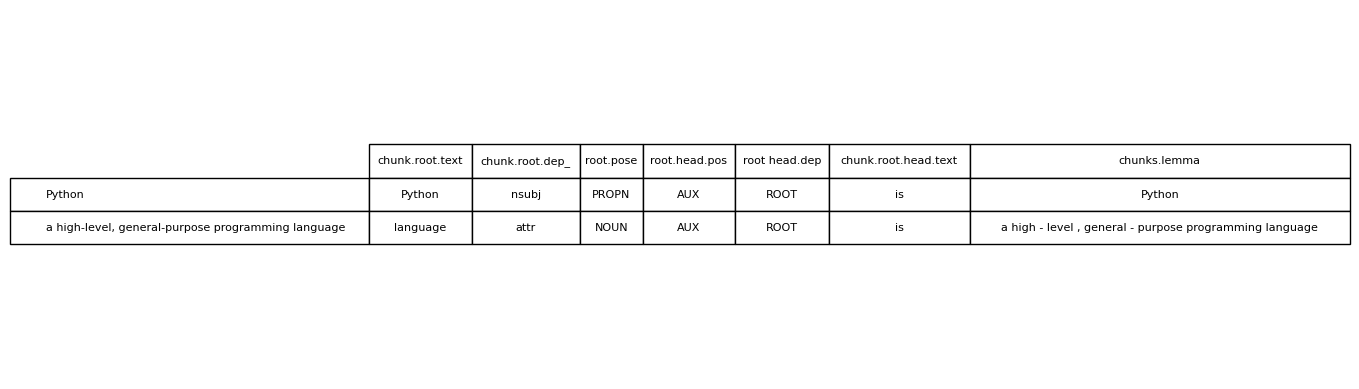

In [10]:
#noun chunk表
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_,
            chunk.root.head.text)
    
fig, ax = plt.subplots()
rows=['chunk.root.text','chunk.root.dep_','root.pose','root.head.pos','root head.dep','chunk.root.head.text','chunks.lemma']
cell=[
        [t.root.text for t in doc.noun_chunks],
        [t.root.dep_ for t in doc.noun_chunks],
        [t.root.pos_ for t in doc.noun_chunks],
        [t.root.head.pos_ for t in doc.noun_chunks],
        [t.root.head.dep_ for t in doc.noun_chunks],
        [t.root.head.text for t in doc.noun_chunks],
        [t.lemma_ for t in doc.noun_chunks]
]
ax.axis("off")
table = plt.table(
        cellText=np.array(cell).T.tolist() ,
        colLabels= rows,
        rowLabels=[t.text for t in doc.noun_chunks],
        cellLoc='center',
        loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(cell)))) 

table.scale(6,2)

In [11]:
#查看 pos等資訊
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])


Python nsubj is AUX []
is ROOT is AUX [Python, language, .]
a det language NOUN []
high amod level NOUN []
- punct level NOUN []
level nmod language NOUN [high, -]
, punct language NOUN []
general amod purpose NOUN []
- punct purpose NOUN []
purpose compound programming NOUN [general, -]
programming compound language NOUN [purpose]
language attr is AUX [a, level, ,, programming]
. punct is AUX []


In [12]:
[t.dep_ for t in doc]

['nsubj',
 'ROOT',
 'det',
 'amod',
 'punct',
 'nmod',
 'punct',
 'amod',
 'punct',
 'compound',
 'compound',
 'attr',
 'punct']

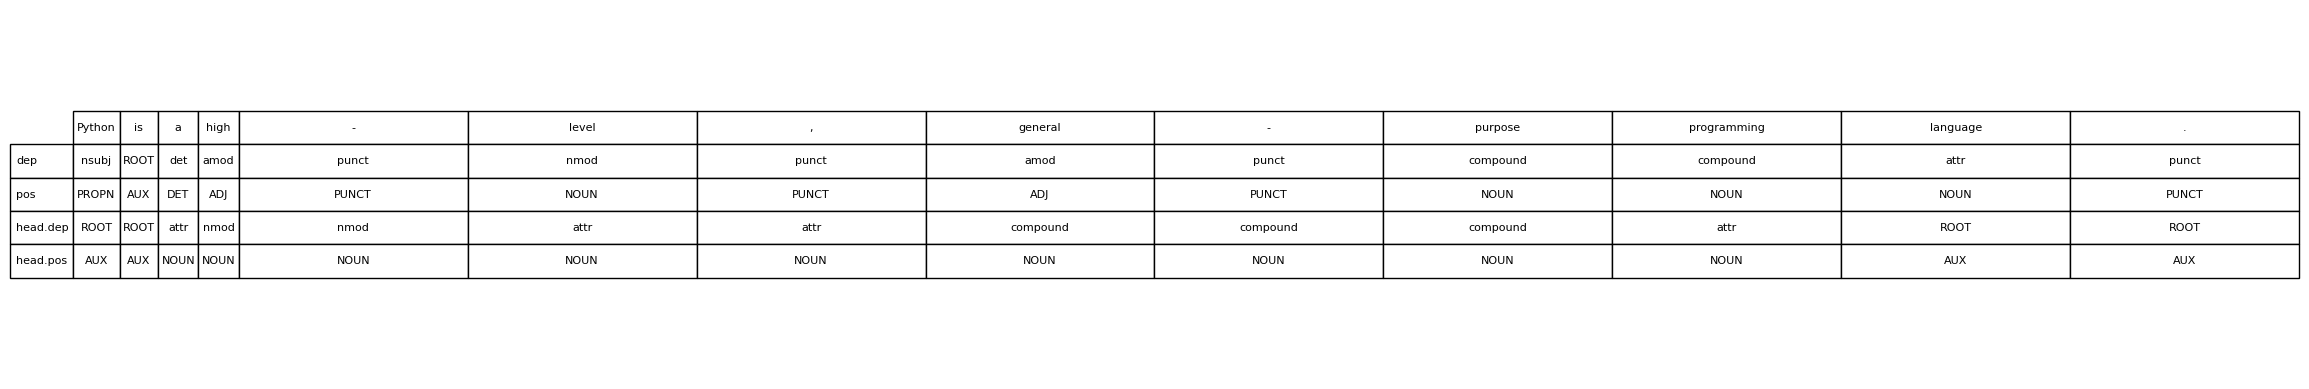

In [13]:
#pos , dep 表
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
rows=['dep','pos','head.dep','head.pos']
cell=[
        [t.dep_ for t in doc],
        [t.pos_ for t in doc],
        [t.head.dep_ for t in doc],
        [t.head.pos_ for t in doc]
]
ax.axis("off")
table = plt.table(
        cellText=cell ,
        colLabels= [t.text for t in doc],
        rowLabels=rows,
        cellLoc='center',
        loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(cell)))) 

table.scale(6,2)